# Reading the input example image

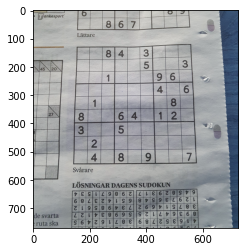

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
import hough
from hough_accumulator import HoughAccumulator


image_path = Path(os.path.abspath('')).joinpath("example.png")
assert image_path.is_file()
img = cv2.imread(str(image_path))
plt.imshow(img)

# Finding the large Sudoku box

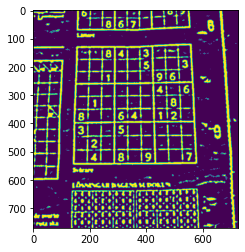

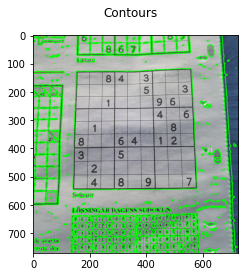

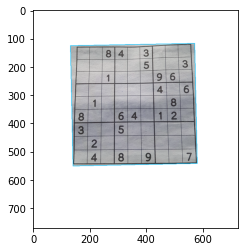

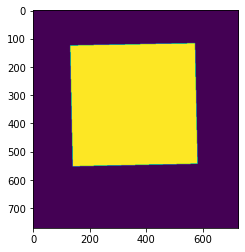

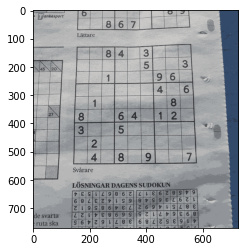

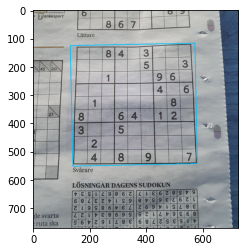

In [2]:
import cv2
import numpy as np

# Kmeans color segmentation
def kmeans_color_quantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = image.reshape((w*h, 3)).astype(np.float32)

    compactness, labels, centers = cv2.kmeans(samples,
            clusters, 
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
            rounds, 
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

# Load image and perform kmeans
img2 = img.copy()
kmeans = kmeans_color_quantization(img2, clusters=8)

# Convert to grayscale, Gaussian blur, adaptive threshold
gray = cv2.cvtColor(kmeans, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (21, 21), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,2)

# Draw largest enclosing rectangle onto a mask
mask = np.zeros(img2.shape[:2], dtype=np.uint8)
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for contour in cnts:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img2,[box],0, color=(0,191,255), thickness=2)
    cv2.drawContours(mask,[box],0, color=255, thickness=-1)
    break

img_contours = img.copy()
cv2.drawContours(img_contours, cnts, -1, [0, 255, 0], 2)

# Bitwise-and for result
result = cv2.bitwise_and(img2, img2, mask=mask)
result[mask==0] = (255,255,255)

plt.figure()
plt.imshow(thresh)
fig = plt.figure()
fig.suptitle("Contours")
plt.imshow(img_contours)
plt.figure()
plt.imshow(result)
plt.figure()
plt.imshow(mask)
plt.figure()
plt.imshow(kmeans)
plt.figure()
plt.imshow(img2)

# Getting outer points of detected rectangle

88.8982925415039
-43.898292541503906


(-320.84409252127136, 334.1066918130708, -325.5312082036192, 329.419576130723)

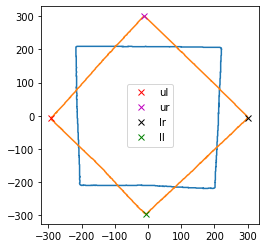

In [11]:
import math
contour1 = contour.reshape(contour.shape[0], 2)

M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
center = np.array([[cX, cY]])
contour1 = contour1 - center
plt.plot(contour1[:, 0], contour1[:, 1])

angle = rect[2]
print(angle)
angle = 45 - angle
print(angle)
contour1 = contour1 @ np.array([
    [math.cos(math.radians(angle)), math.sin(math.radians(angle))],
    [-math.sin(math.radians(angle)), math.cos(math.radians(angle))]
])
plt.plot(contour1[:, 0], contour1[:, 1])

i_ul = np.argmin(contour1[:, 0])
i_lr = np.argmax(contour1[:, 0])
i_ll = np.argmin(contour1[:, 1])
i_ur = np.argmax(contour1[:, 1])

plt.plot(*contour1[i_ul], 'rx', label="ul")
plt.plot(*contour1[i_ur], 'mx', label="ur")
plt.plot(*contour1[i_lr], 'kx', label="lr")
plt.plot(*contour1[i_ll], 'gx', label="ll")
plt.legend()
ax = plt.gca()
ax.axis("square")

# Plot back on original

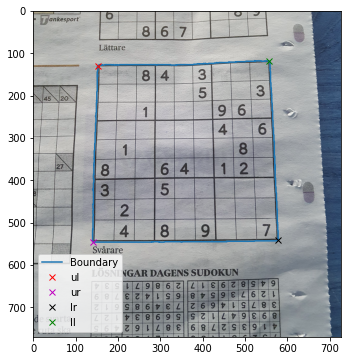

In [4]:
fig = plt.figure()
fig.set_size_inches(6, 6)
plt.imshow(img)
plt.plot(contour[:, 0, 0], contour[:, 0, 1], label="Boundary")

plt.plot(*contour[i_ul, 0], 'rx', label="ul")
plt.plot(*contour[i_ur, 0], 'mx', label="ur")
plt.plot(*contour[i_lr, 0], 'kx', label="lr")
plt.plot(*contour[i_ll, 0], 'gx', label="ll")
plt.legend()

pts1 = np.array([contour[i_ul, 0], contour[i_ur, 0], contour[i_lr, 0], contour[i_ll, 0]], dtype=np.float32)

# Rectifying the box from the corners into a rectangular image of fixed size

Drawing point [152. 130.]
Drawing point [141. 545.]
Drawing point [578. 541.]
Drawing point [557. 119.]


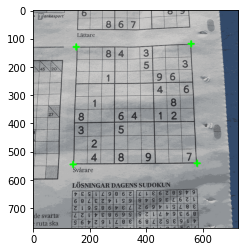

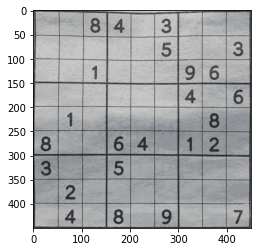

In [5]:
import math

def rect_to_points(x0, y0, width, height, angle):
    _angle = angle * math.pi / 180.0
    b = math.cos(_angle) * 0.5
    a = math.sin(_angle) * 0.5
    pt0 = (
        x0 - a * height - b * width,
        y0 + b * height - a * width,
    )
    pt1 = (
        x0 + a * height - b * width,
        y0 - b * height - a * width,
    )
    pt2 = (
        2 * x0 - pt0[0],
        2 * y0 - pt0[1],
    )
    pt3 = (
        2 * x0 - pt1[0],
        2 * y0 - pt1[1],
    )
    return np.float32([
        pt0, pt1, pt2, pt3
    ])

img_points = kmeans.copy()
for pt in pts1:
    print(f"Drawing point {pt}")
    img_points = cv2.drawMarker(img_points, pt.astype(int), [0, 255, 0], thickness=5)
plt.imshow(img_points)

pts2 = np.float32([[0,0],[0,450],[450,450],[450,0]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imagewrap = cv2.warpPerspective(kmeans,matrix,(450,450))

plt.figure()
plt.imshow(imagewrap)

# Getting Hough accumulator from image

Text(0.5, 0, 'Offset [px]')

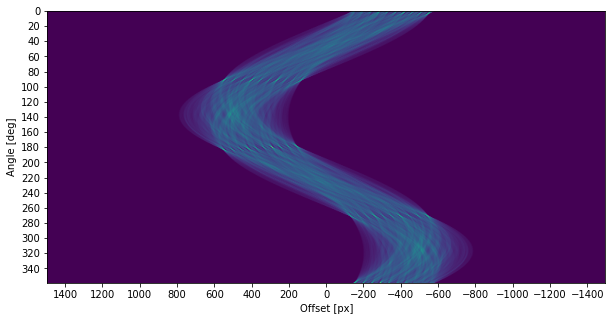

In [6]:
import scipy.ndimage

img_canny = cv2.bitwise_and(thresh, thresh, mask=mask)
accum = HoughAccumulator(img_canny)

fig = plt.figure()
fig.set_size_inches(10, 5)
local_maxes = scipy.ndimage.maximum_filter(accum, size=5)
plt.imshow(accum.acc, extent=[accum.col_to_rho(-1), accum.col_to_rho(0), accum.row_to_theta(-1), accum.row_to_theta(0)])  #, norm=LogNorm(vmin=1, vmax=1e2))
ax = plt.gca()
ax.set_aspect(aspect="auto")
ax.locator_params(nbins=20)
ax.set_ylabel("Angle [deg]")
ax.set_xlabel("Offset [px]")

# Distribution of Hough line intensities

(array([0.82074321, 0.82104773, 0.82121484, 0.82135224, 0.82146737,
        0.82158806, 0.82175703, 0.82192971, 0.82214325, 0.82237906,
        0.82254617, 0.82280056, 0.8230178 , 0.82325362, 0.82353957,
        0.82381809, 0.82408362, 0.82439742, 0.8248282 , 0.82553936,
        0.82663859, 0.82788451, 0.82918428, 0.83043949, 0.8314923 ,
        0.83235943, 0.83315601, 0.8338486 , 0.83461546, 0.83534519,
        0.83617147, 0.83695691, 0.83775719, 0.83864661, 0.83949888,
        0.84042915, 0.84129999, 0.84222469, 0.84303797, 0.84398866,
        0.84489293, 0.84578048, 0.84669218, 0.8475166 , 0.84836145,
        0.84919145, 0.84999359, 0.85081245, 0.85160531, 0.85242416,
        0.85322631, 0.85406559, 0.854942  , 0.85579242, 0.8567134 ,
        0.85756754, 0.85840867, 0.85921824, 0.86011323, 0.86092094,
        0.86165624, 0.86252523, 0.86338865, 0.86413694, 0.86490752,
        0.8655834 , 0.86639112, 0.8671227 , 0.86787842, 0.86863229,
        0.86948085, 0.87035913, 0.8712114 , 0.87

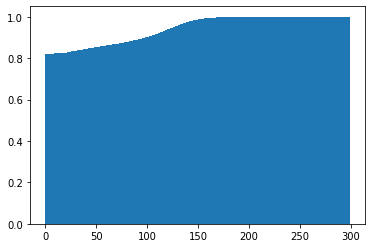

In [7]:
plt.hist(accum.acc.flatten(), bins=range(0, 300), cumulative=True, density=True)

# Finding angles with most prominent lines

[ 45  91 135 225 271 315 345]


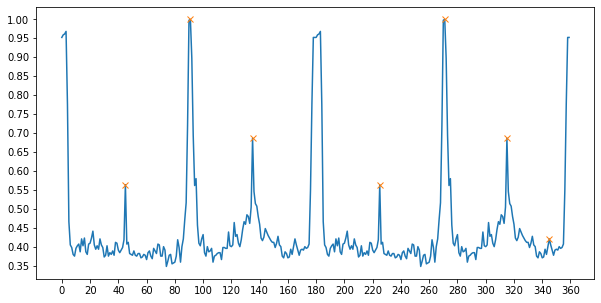

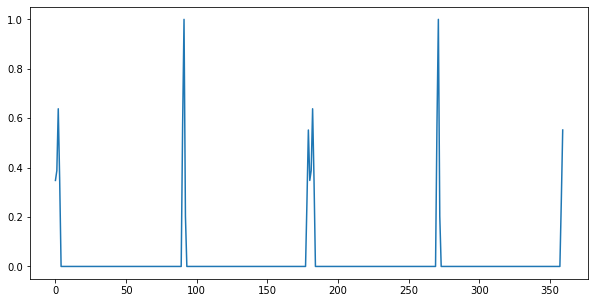

In [8]:
import scipy.signal

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.locator_params(nbins=20)
ys1 = np.amax(accum.acc, axis=1)
angles = np.arange(180)
peaks, _ = scipy.signal.find_peaks(ys1, distance=30, prominence=10, width=(None, 5))
print(peaks)
plt.plot(ys1 / np.amax(ys1))
plt.plot(peaks, ys1[peaks] / np.amax(ys1), 'x')
fig = plt.figure()
fig.set_size_inches(10, 5)
thresh = np.amax(accum.acc.flatten()) * 0.8
accum2 = accum.acc.copy()
accum2[accum.acc < thresh] = 0
ys2 = np.sum(accum2, axis=1)
plt.plot(ys2 / np.amax(ys2))

# Detecting and drawing Hough lines

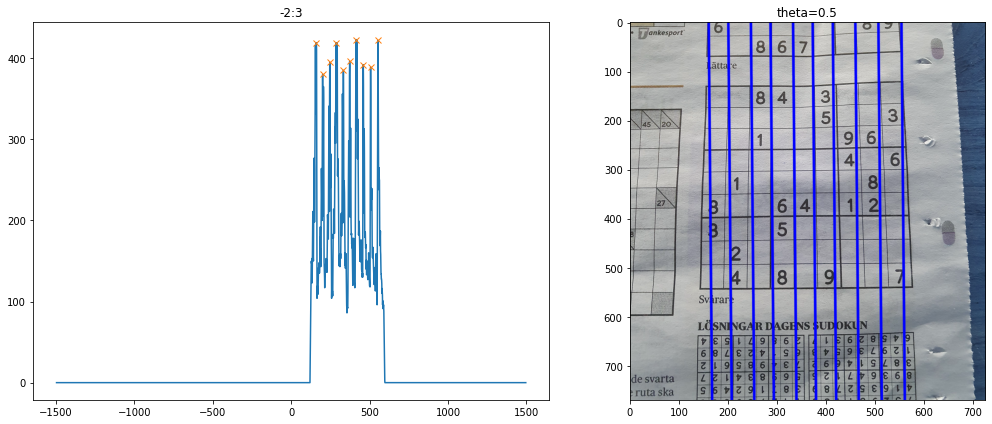

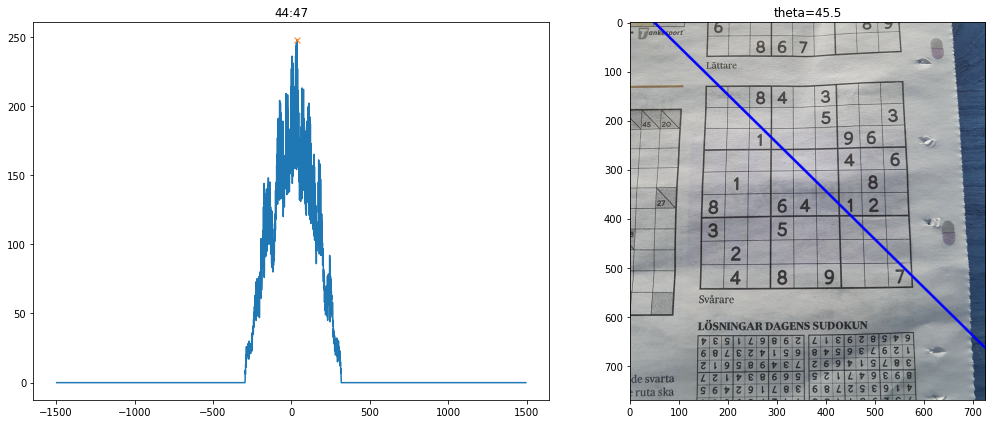

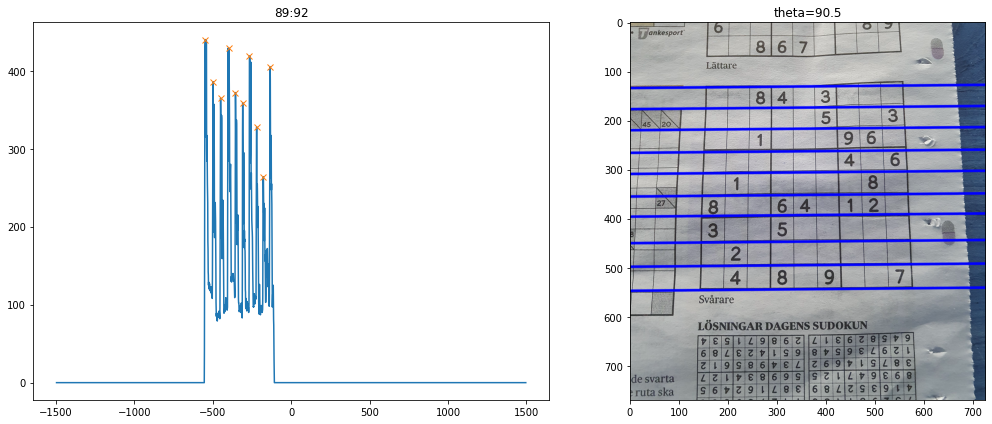

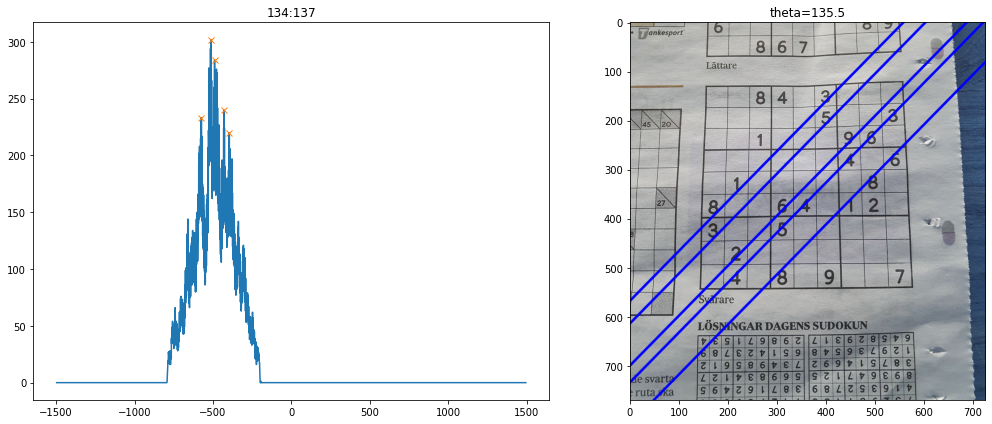

In [9]:
import scipy.signal
import math

accum_raw = accum.acc.copy()
rows, cols = accum_raw.shape
tops = ((0, 2), (45, 1), (90, 1), (135, 1))
for mid, width in tops:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    a = mid - width
    b = mid + width + 1
    if a < 0:
        acc = np.vstack((accum_raw[a:], accum_raw[0:b]))
    elif b > rows:
        acc = np.vstack((accum_raw[a:], accum_raw[0:b-rows]))
    else:
        acc = accum_raw[a:b]
    ys = np.amax(acc, axis=0)
    # ys_bg = scipy.signal.medfilt(ys, 11)
    xs = np.arange(len(ys))
    xs = xs - len(xs) / 2
    y_max = np.amax(ys)
    ax1.plot(xs, ys)
    ax1.set_title(f"{a}:{b}")
    fig.set_size_inches(15, 6)
    fig.set_tight_layout(True)
    img_copy = img.copy()

    theta = sum((a, b)) / 2
    rhos, _ = scipy.signal.find_peaks(ys, distance=20, prominence=100)
    ax1.plot(xs[rhos], ys[rhos], 'x')
    for rho in xs[rhos]:
        a = math.cos(theta * math.pi / 180)
        b = -math.sin(theta * math.pi / 180)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*b), int(y0 - 1000*a))
        pt2 = (int(x0 - 1000*b), int(y0 + 1000*a))
        cv2.line(img_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    ax2.imshow(img_copy)
    ax2.set_title(f"theta={theta}")